Main performance metrics for Datasets
Confusion Metrix


##**Import Packages**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoModelForSequenceClassification, AutoTokenizer


In [ ]:

class Model:
    def __init__(self):
        torch.set_grad_enabled(False)
        torch.set_num_threads(1)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained("./olu_model")
        self.classifier = AutoModelForSequenceClassification.from_pretrained("./olu_model")
        self.classifier.to(self.device)
        self.classifier.eval()
    def predict(self, text):
        encoded_text = self.tokenizer.encode_plus(
            text,
            max_length=150,
            add_special_tokens=True,
            return_token_type_ids=False,
            pad_to_max_length=False,
            return_attention_mask=True,
            return_tensors="pt",
            truncation=True,
        )
        input_ids = encoded_text["input_ids"].to(self.device)
        attention_mask = encoded_text["attention_mask"].to(self.device)
        inferences = []
        predictions = self.classifier(input_ids, attention_mask)
        results = predictions["logits"].tolist()[0]
        inferences.append(results)
        return inferences

In [ ]:
#Instantiating the model
pred = Model()

In [ ]:
#testing out a prediction
np.argmax(pred.predict("I hate Muslim people"))

[2021-11-16 14:53:03.483 pytorch-1-6-cpu-py36-u-ml-c5-large-d3b44260bba1e2e53aa6c50c7222:654 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-11-16 14:53:03.545 pytorch-1-6-cpu-py36-u-ml-c5-large-d3b44260bba1e2e53aa6c50c7222:654 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


1

For model evaluation, the following datasets was used; 
1.   Hatecheck
2.   Dynabench
3.   Founta
4.   Davidson 



In [ ]:
df_path = "dynabench.csv" #file path 
df =pd.read_csv(df_path)

In [ ]:
df= df[['text', 'label']]
#df =df.sample(20)

In [ ]:
df

,text,label
0,dalits are lowlives,1
1,It was a better world when women dare not ques...,1
2,I don't work this hard so that those immigrant...,1
3,I don't work this hard so that those foreigner...,1
4,I don't work this hard so that those chavs can...,1
...,...,...
9995,I have that opinion. absolutely everyone I act...,0
9996,"This dark female, I am not going to use the hu...",1
9997,I guess you are assuming that the french laws ...,1
9998,"I mean, theres no one better right now to give...",0


In [ ]:
#function to generate predictions
def predict(text):
    return np.argmax(pred.predict(text))

In [ ]:
#function to generate classification report 
def report(df, pred):
    df["predictions"] = df["text"].apply(lambda x:predict(x))
    return classification_report(df["label"], df["predictions"])

#function to generate confusion matrix
def confusion(true,prediction):
    cf_matrix = confusion_matrix(df["label"], df["predictions"])
    conf =sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g')
    return conf

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      4626
           1       0.91      0.84      0.87      5374

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



<AxesSubplot:>

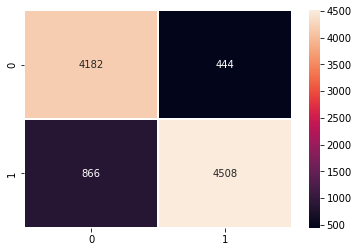

In [ ]:
# printing the metrics and plotting the confusion metrics by calling their respective functions

print(report(df,pred))
confusion(df["label"], df["predictions"])

In [ ]:
#function to generate misclasified text
def error(df):
    df["predictions"] = df["text"].apply(lambda x:predict(x))
    df_errors = df[df['label'] !=df['predictions']]
    return df_errors
    

In [ ]:
#generating a csv file of misclassified text
error(df).to_csv('errors.csv')